In [1]:
import numpy as np
import random
import torch

import os
import PIL
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.models as models
from torchvision.utils import make_grid, save_image

import json

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# from utils import visualize_cam, Normalize, load_image, plot_gradcam, get_gradcam
# from gradcam import GradCAM, GradCAMpp

from attn_model2 import *

import matplotlib.pyplot as plt

from helpers import *
# from utils import *

from utils2 import *

In [2]:
# def manhattan(a, b):
#     return sum(abs(val1-val2) for val1, val2 in zip(a,b))

In [3]:
# def EuclideanDistances(A, B):
#     BT = B.transpose()
#     # vecProd = A * BT
#     vecProd = np.dot(A,BT)
#     # print(vecProd)
#     SqA =  A**2
#     # print(SqA)
#     sumSqA = np.matrix(np.sum(SqA, axis=1))
#     sumSqAEx = np.tile(sumSqA.transpose(), (1, vecProd.shape[1]))
#     # print(sumSqAEx)
 
#     SqB = B**2
#     sumSqB = np.sum(SqB, axis=1)
#     sumSqBEx = np.tile(sumSqB, (vecProd.shape[0], 1))    
#     SqED = sumSqBEx + sumSqAEx - 2*vecProd
#     SqED[SqED<0]=0.0   
#     ED = np.sqrt(SqED)
#     return ED

In [4]:
image_names = get_png_names("../pooling/data/MEX2/")[0:5]
y = get_migrants("../pooling/data/migration_data.json" , image_names)

5 municipalities.


In [5]:
# hm = load_inputs(image_names[0])#.to(device)
# plt.imshow(hm[0].permute(1,2,0))

In [6]:
BATCH_SIZE = 1

x_train, y_train, x_val, y_val = train_test_split(np.array(image_names), np.array(y), .9)

train = [(k,v) for k,v in zip(x_train, y_train)]
val = [(k,v) for k,v in zip(x_val, y_val)]

train_dl = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
val_dl = torch.utils.data.DataLoader(val, batch_size = BATCH_SIZE, shuffle = True)

for i, o in val_dl:
    print(i[0].split("/")[4])

484004001


OKAY – SO MAYBE THIS NEEDS TO BE BASED MORE ON GRADIENT THRESHOLDS – I.E. INSTEAD OF WHEN THE LOSS HITS A POINT THEN CLIP THE IMAGE, DO WHEN THE GRADIENT HASN’T CHANGED BY X% IN THE PAST X EPOCHS, CLIP THE IMAGE. COULD ALSO INSTEAD ASSIGN SCORES TO EACH PIXEL BASED ON THEIR RELATIVE IMPORTANCE AT EACH EPOCH AND ONCE A PIXEL CROSSES A TRHESHOLF O RELATIVE IMPORTANCE, THEN CLIP THE IMAGE <- YOU REALLY LIKE THIS IDEA

### t/v with clipping

In [7]:
# threshold_index = 7
# epoch_loss = 100000000

# # for i in range(25):
# i = 0
# while epoch_loss > 0:
    
#     running_train_loss, running_val_loss = 0, 0
    
#     for input, output in val_dl:
        
#         muni_id = input[0].split("/")[4]
                
#         input = load_inputs(input[0]).to(device)
        
#         if (threshold_index < 6):
#             input = prep_input(muni_id, sizes_dict, input).to(device)
# #             print("Clipping input image.")
        
#         model.train()
#         y_pred = model(input)    
#         loss = criterion(y_pred, output.to(device))
        
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         running_train_loss += loss.item()
        
        
#         if muni_id == "484002003":
            
#             IM_SIZE = (input.shape[2], input.shape[3])

#             model.eval()
#             test_ims, test_arr = get_gradcam(model, IM_SIZE, input.cuda())  

#             plot_gradcam(test_ims)
#             plt.savefig(f"./{muni_id}/epoch{i}_gradcam.png")
# #             plt.clf()
            
#             if muni_id in sizes_dict.keys():
#                 distance_dict[muni_id] = torch.cat((distance_dict[muni_id], torch.tensor(test_arr).unsqueeze(0)))
#             else:
#                 distance_dict[muni_id] = torch.tensor(test_arr).unsqueeze(0)


#     print("Epoch: ", i)
#     print("  Train Loss: ", running_train_loss / len(val_dl))
    
#     epoch_loss = running_train_loss / len(val_dl)

    
#     # After the first epoch...
#     if i == 0:

#         # Calculate 0, 20, 40, 60, & 80 percent loss thresholds
#         loss_thresholds = calc_loss_thresholds(epoch_loss)
#         threshold_index = 6
#         cur_threshold = loss_thresholds[threshold_index]     

#         print("  Loss thresholds based of baseline loss: ", loss_thresholds)
        
        
#     # If the loss falls below the current threshold
#     if epoch_loss < cur_threshold:
                
#         # Set the new threshold
#         threshold_index -= 1
#         cur_threshold = loss_thresholds[threshold_index]
#         print("  Moving to threshold: ", threshold_index, "  |  Next loss benchmark: ", cur_threshold)
        
#         for inp, out in val_dl:
            
#             muni_id = inp[0].split("/")[4]
#             cur_im = load_inputs(inp[0]).to(device)
            
#             if muni_id in sizes_dict.keys():
                
#                 cur_im = prep_input(muni_id, sizes_dict, cur_im).to(device)            
            
#             if i == 0:
                
#                 sizes_dict[muni_id] = (0, cur_im.shape[0], 0, cur_im.shape[1])
                
#             if i != 0:
                
#                 IM_SIZE = (cur_im.shape[2], cur_im.shape[3])
                
# #                 print(IM_SIZE)
#                 model.eval()
#                 test_ims, test_arr = get_gradcam(model, IM_SIZE, cur_im.cuda())  
#                 cur_im, new_indices = clip_input(cur_im, test_arr)#.to(device)
# #                 print("New image shape: ", cur_im.shape)       
#                 sizes_dict[muni_id] = new_indices
    
# #         if muni_id == "484002003":

# #             plot_gradcam(test_ims)
# #             plt.savefig(f"{muni_id}epoch{i}_shape{cur_im.shape}.png")
# #             plt.clf()

# #             plt.imshow(cur_im[0].permute(1,2,0))
# #             plt.savefig(f"{muni_id}epoch{i}_v2.png")
# #             plt.clf()
                    

        
#     i += 1
#     print("\n")

In [8]:
# def calc_distances(distances):
#     all_distances = []
#     for i in range(distances.shape[0] - 1):
# #         try:
#         cur_dist = manhattan(np.array(distances[i]), np.array(distances[i + 1]))
#         print(np.mean(cur_dist))
#         all_distances.append(np.mean(cur_dist))
#     for i in range(len(all_distances) - 1):
#         print(((all_distances[i + 1] - all_distances[i]) / all_distances[i]) * 100)

In [9]:
# def calc_distances(distances):
#     all_distances = []
#     for i in range(distances.shape[0] - 1):
# #         try:
#         cur_dist = manhattan(np.array(distances[i]), np.array(distances[i + 1]))
#         print(cur_dist.shape)
#         all_distances.append(cur_dist)
#     for i in range(len(all_distances) - 1):
#         print(np.mean(((all_distances[i + 1] - all_distances[i]) / all_distances[i])))

In [10]:
# calc_distances(distance_dict['484002003'])

In [11]:
# def handle_distance(muni_ids, distances_dict, diff_dict):
#     """
#     If there is a less than 5% change in the mean of the distances between the attenion heatmaps for 3 or more epochs, do what you will
#     """
    

In [68]:
class ZoomNetHandler():
    
    """
    Class to control the training of the ZoomNet
    Initialize at the bgeiining of training to handle all of the variables 
    """
    
    def __init__(self, model, device, criterion, optimizer):
        
        self.image_sizes = {}
        self.distance_dict = {}
        self.diff_dict = {}
        self.epoch_train_loss = 0
        self.cur_threshold = 0
        self.epoch = 0
        self.loss_thresholds = []
        self.loss = 0
        self.threshold_index = 7
        self.device = device
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.running_train_loss = 0
        self.running_val_loss = 0
        
        self.to_tens = transforms.ToTensor()
        
        
    def update_handler(self, train_dl):
        
        """
        General function that ingests the current status of the model and updates what needs to be updated (:
        """
                
        # After the first epoch, calculate all of the loss thresholds and set the beginning threshold index
        if self.epoch == 0:
            
            # Calculate 0, 20, 40, 60, & 80 percent loss thresholds
            self.loss_thresholds = self.__calc_loss_thresholds()
            self.threshold_index = 6
            self.cur_threshold = self.loss_thresholds[self.threshold_index]   
            
            print("Loss thresholds for training: ", self.loss_thresholds)
            print("Starting from threshold: ", self.threshold_index, " with value: ", self.cur_threshold)
            
            
        # If the loss of the most recent epoch falls below the current threshold...
        if self.epoch_train_loss < self.cur_threshold:
            
            print("HEERE")
            
            # Set the new threshold
            self.threshold_index -= 1
            self.cur_threshold = self.loss_thresholds[self.threshold_index]
            print("  Moving to threshold: ", self.threshold_index, "  |  Next loss benchmark: ", self.cur_threshold)
            
            # Update the sizes of the images in the dictionary (this happens each time we pass a threshold)
            self.update_image_sizes(train_dl)
         
        
    def __calc_loss_thresholds(self):
        
        """
        Function to calculate the loss thresholds for the trianing loop (these don't change after being calculated)
        """
        
        breaks = self.epoch_train_loss / 7
        breaks = [(i * breaks) for i in range(7)]
        return breaks
        
        
    def update_image_sizes(self, data):
        
        """
        Function to update the image sizes in the dictionary based on the gradcam heatmap for each of the images in the training dataset
        """
        
        # For each of the images in the training dataset
        # inp = (img_name,)
        # out = y
        for inp, out in data:

            # Grab the municipality ID from the image name and load the image (TO-DO: PUT LOAD_INPUTS IN THIS CLASS)
            muni_id = inp[0].split("/")[4]
            cur_image = handler.prep_input(inp)

            # If the municipality is already in the image_sizes dict, that means it has already been see and the image_size might be different
            # from the original, so grab the most updated image size from the dictionary and clip the image to those dimensions
            if muni_id in self.image_sizes.keys():
                cur_im = prep_input(muni_id, self.image_sizes, cur_image).to(device)            
            
            # If it's the first epoch, add the muni_id to the dictionary and the size of the original image in format: (x_min, x_max, y_min, y_max)
            if i == 0:
                self.image_sizes[muni_id] = (0, cur_image.shape[0], 0, cur_image.shape[1])

            # If it's past the first epoch...
            elif i != 0:
                    
                # Get the size of the image
                IM_SIZE = (cur_image.shape[2], cur_image.shape[3])
                
                model.eval()
                
                # Get the gradcam and the attention heatmap for the current image
                gradcam, attn_heatmap = get_gradcam(self.model, IM_SIZE, cur_image.cuda())  
                cur_image, new_dims = self.__clip_input(cur_image, attn_heatmap)
                
                print("\n")
                print(muni_id)
                print("old image size: ", IM_SIZE)
                print("new image size: ", cur_image.shape[2], cur_image.shape[3])
                
                cur_image.cpu()
                
                # Update the image sizes in the dictionary
                self.image_sizes[muni_id] = new_dims           

                
    def __clip_input(self, input, test_arr):
        
        """
        Function to clip the input based on the attention heatmap
        TO-DO: CLEAN UP THE VARIABLE NAMES HERE - THE LAST TIME YOU TRIED SOMETHING FUNKY HAPPENED (THE IMAGES DIDIN'T ACTUALLY CLIP) SO COME BACK TO IT
        """
                
        # Get the indices of the heatmap of the max value of the heatmap
        result = np.where(test_arr == np.max(test_arr))
        
        # Calculate the dimensions that corespond to X% of the most recent image size
        sh = test_arr.shape
        sh = (int(sh[0] * .60), int(sh[1] * .60))

        left = sh[0]
        right = sh[1]
        ni, nj = test_arr.shape 

        min_row, max_row = 50000, 0
        min_col, max_col = 50000, 0

        # If the number of idices that are the max are exxcessive, just use the first
        # TO-DO: CONSIER A BETTER WAY OF DOING THIS
        if (len(result[0]) > 100) or (len(result[1])  > 100):
            result = (np.array([result[0][0]]), np.array([result[1][0]]))

        # For every x,y max index, do stuff (:
        for i, j in zip(result[0], result[1]):

            istart, istop = max(0, i-left), min(left, i+left+1)
            jstart, jstop = max(0, j-right), min(right, j+right+1)            

            if istart < min_row:
                min_row = istart
            if jstart < min_col:
                min_col = jstart   
            if istop > max_row:
                max_row = istop    
            if jstop > max_col:
                max_col = jstop  

        input = input.detach().cpu()[:, :, min_row:max_row, min_col:max_col]
        indices = (min_row, max_row, min_col, max_col)

        return input, indices
        
        
    def prep_input(self, impath):
        
        """
        Function to load in an image and clip it to it's most updated size
        TO-DO: SEE IF YOU CAN DO THE CLIPPING WITHOUT DETACHING FROM THE GPU
        """
        
        muni_id = impath[0].split("/")[4]
        
        # Load the image as a tensor
        image = self.to_tens(Image.open(impath[0]).convert('RGB')).unsqueeze(0)
        
        # If the muni_id is in the image_sizes dictionary, clip it to the right size
        if muni_id in self.image_sizes.keys():
        
            dims = self.image_sizes[muni_id]
            image = image.detach().cpu()[:, :, dims[0]:dims[1], dims[2]:dims[3]]
        
        return image.to(self.device)
        
        
    def calc_distances():
        pass
    
    
    def train(self, input, output):
        
        """
        Train model using an input
        """
        
        self.model.train()
        y_pred = self.model(input)    
        loss = self.criterion(y_pred, output.to(self.device))
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.running_train_loss += loss.item()
        

    def end_epoch(self, train_dl, val_dl):
        
        """
        Print a message to the user with the epoch stats and do all of the neccessary updates
        """
        
        self.epoch_train_loss = self.running_train_loss / len(train_dl)
        
        print("Epoch: ", self.epoch)
        print("  Training Loss: ", self.epoch_train_loss)
        
        self.update_handler(train_dl)
#         self.epoch_val_loss = self.running_val_loss / len(val_dl)

    
        self.running_train_loss = 0
#         self.running_val_loss = 0
        
        self.epoch += 1

In [69]:
# base = "../census/MEXimagery/2010/"

# for i in os.listdir(base):
#     print(len(os.listdir(os.path.join(base, i))))

In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18 = models.resnet18().to(device)
model = attnNetBinary(in_channels = 512, h = 7, w = 7, batch_size = 1, resnet = resnet18).to(device)
lr = .0001
criterion = torch.nn.L1Loss(reduction = 'mean')
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

handler = ZoomNetHandler(model, device, criterion, optimizer)

In [71]:
for i, o in train_dl:
    print(load_inputs(i[0]).shape)

handler.image_sizes

torch.Size([1, 3, 1328, 1971])
torch.Size([1, 3, 1320, 2383])
torch.Size([1, 3, 1488, 3072])
torch.Size([1, 3, 1794, 2752])


{}

In [72]:
for i in range(20):

    for impath, output in train_dl:

        # Prep the input and pass it to the trainer (this could easily be done in one step eventually if ya want)
        input = handler.prep_input(impath)
        handler.train(input, output)
    
    handler.end_epoch(train_dl, val_dl = None)

Epoch:  0
  Training Loss:  10409.267577171326
Loss thresholds for training:  [0.0, 1487.0382253101893, 2974.0764506203786, 4461.114675930568, 5948.152901240757, 7435.191126550946, 8922.229351861137]
Starting from threshold:  6  with value:  8922.229351861137
Epoch:  1
  Training Loss:  10391.2267537117
Epoch:  2
  Training Loss:  10364.441274642944
Epoch:  3
  Training Loss:  10347.782925605774
Epoch:  4
  Training Loss:  10233.581153869629
Epoch:  5
  Training Loss:  10159.3180103302
Epoch:  6
  Training Loss:  9830.122888565063
Epoch:  7
  Training Loss:  9504.296127319336
Epoch:  8
  Training Loss:  9489.265338897705
Epoch:  9
  Training Loss:  9181.044090270996
Epoch:  10
  Training Loss:  9215.514770507812
Epoch:  11
  Training Loss:  8837.604568481445
HEERE
  Moving to threshold:  5   |  Next loss benchmark:  7435.191126550946
Clipping input


484004004
old image size:  (1320, 2383)
new image size:  792 1429
Clipping input


484004006
old image size:  (1328, 1971)
new image size

KeyboardInterrupt: 

In [73]:
1488 * .60

892.8

In [ ]:
distance_dict['484002003'].shape

In [46]:
for i in distance_dict['484002003']:
    print(torch.mean(torch.tensor(i, dtype = torch.float32)))

tensor(112.9373)
tensor(107.5682)
tensor(108.6621)
tensor(108.2476)
tensor(109.2387)
tensor(109.6338)
tensor(110.3670)
tensor(106.8865)
tensor(109.0544)
tensor(113.5746)
tensor(113.5377)
tensor(112.4567)
tensor(117.2377)


/opt/conda/envs/rapids/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


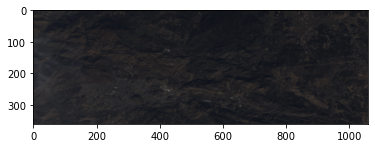

In [32]:
plt.imshow(cur_im[0].permute(1,2,0))

In [31]:
cur_im.shape

torch.Size([1, 3, 360, 1060])

In [244]:
sizes_dict

{'484004001': (772, 2732, 0, 1324), '484002004': (254, 1318, 0, 2752)}

In [161]:
# IMAGE_INDEX = 7

# input = load_inputs(image_names[IMAGE_INDEX]).to(device)
# output = torch.tensor([y[IMAGE_INDEX]]).to(device)

# for i in range(50):
        
#     print("Epoch: ", i)
    
    
#     model.train()
#     y_pred = model(input)    
#     loss = criterion(y_pred, output)
#     print("  Loss: ", loss.item())
    
    
#     IM_SIZE = (input.shape[2], input.shape[3])
#     model.eval()
#     test_ims, test_arr = get_gradcam(model, IM_SIZE, input.cuda())   

    
    
#     # After the first epoch...
#     if i == 0:
        
#         # Calculate 0, 20, 40, 60, & 80 percent loss thresholds
#         loss_thresholds = calc_loss_thresholds(loss)
#         threshold_index = 6
#         cur_threshold = loss_thresholds[threshold_index]
        
#         print("  Loss thresholds based of baseline loss: ", loss_thresholds)
                
    
        
#     # If the loss falls below the current threshold
#     if loss.item() < cur_threshold:
                
#         # Set the new threshold
#         threshold_index -= 1
#         cur_threshold = loss_thresholds[threshold_index]
#         print("  Moving to threshold: ", threshold_index, "  |  Next loss benchmark: ", cur_threshold)
#         input = clip_input(input, test_arr).to(device)
#         print("New image shape: ", input.shape)
        
#         plot_gradcam(test_ims)
#         plt.savefig(f"./test{i}_imgshape{input.shape}_img{IMAGE_INDEX}.png")
    
#         if threshold_index == 1:
            
#             break
            
#     print("\n")


#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

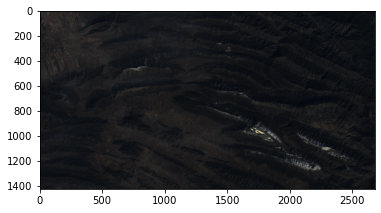

In [10]:
hm = load_inputs(image_names[7])#.to(device)
plt.imshow(hm[0].permute(1,2,0))

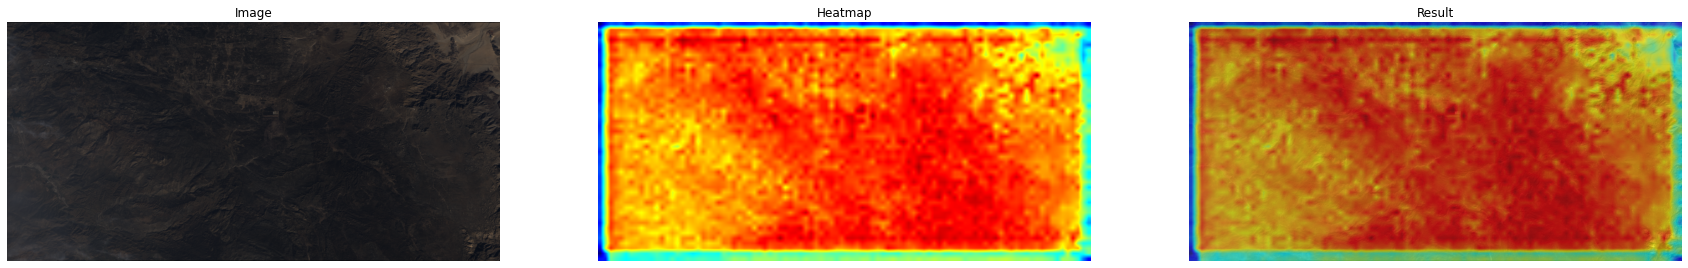

In [10]:
plot_gradcam(test_ims)
plt.savefig("./test.png")